### Import libraries

In [596]:
import logging, sys
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix as cm
from joblib import dump, load

### Load data from Database

In [597]:
try:
    connection = sqlite3.connect("../data/project.sqlite")
    tweets = pd.read_sql_query(f"SELECT * FROM tweets", connection)
    songs = pd.read_sql_query(f"SELECT * FROM songs", connection)
    user_playlist = pd.read_sql_query(f"SELECT * FROM user_playlist", connection)
except sqlite3.Error as e:
    logging.error(msg=f"Error while creating SQLite DB: {e}")
    sys.exit(1)
finally:
    connection.close()

### Tweeter data exploration

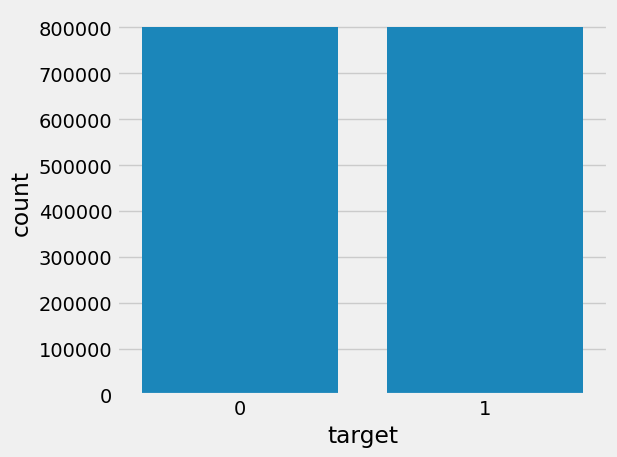

In [598]:
plt.style.use("fivethirtyeight")
sns.countplot(x="target", data=tweets)
plt.tight_layout()
plt.show()

### Spotify Song exploration

In [599]:
positive_tweet = tweets[tweets.target == 1]["processed_text"]
negative_tweet = tweets[tweets.target == 0]["processed_text"]
tweets[tweets.target == 0]["text"].iloc[2]

'my whole body feels itchy and like its on fire '

(-0.5, 399.5, 199.5, -0.5)

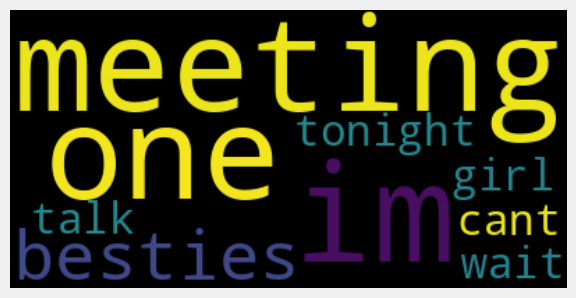

In [600]:
wordcloud = WordCloud().generate(positive_tweet.iloc[1])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

#### User playlist exploration

In [601]:
def plot_playlist_hist(playlist):
    plt.style.use("fivethirtyeight")

    fig, axs = plt.subplots(3,3, figsize=(15, 15))
    fig.delaxes(axs[2][1])
    fig.delaxes(axs[2][2])

    bpm = playlist["bpm"]
    bpm_mean = bpm.mean()
    axs[0,0].hist(bpm, histtype='bar', edgecolor="black")
    axs[0,0].set_title("BPM")
    axs[0,0].set_xlabel("BPM")
    axs[0,0].set_ylabel("Counts")
    axs[0,0].axvline(bpm_mean, color="red", label=f"mean: ({bpm_mean:.2f})")
    axs[0,0].legend()

    danceability = playlist["danceability_%"]
    danceability_mean = danceability.mean()
    axs[0,1].hist(danceability, histtype='bar', edgecolor="black")
    axs[0,1].set_title("Danceability")
    axs[0,1].set_xlabel("Danceability")
    axs[0,1].set_ylabel("Counts")
    axs[0,1].axvline(danceability_mean, color="red", label=f"mean: ({danceability_mean:.2f})")
    axs[0,1].legend()


    energy = playlist["energy_%"]
    energy_mean = energy.mean()
    axs[0,2].hist(energy, histtype='bar', edgecolor="black")
    axs[0,2].set_title("Energy")
    axs[0,2].set_xlabel("Energy")
    axs[0,2].set_ylabel("Counts")
    axs[0,2].axvline(energy_mean, color="red", label=f"mean: ({energy_mean:.2f})")
    axs[0,2].legend()


    acousticness = playlist["acousticness_%"]
    acousticness_mean = acousticness.mean()
    axs[1,0].hist(acousticness, histtype='bar', edgecolor="black")
    axs[1,0].set_title("Acousticness")
    axs[1,0].set_xlabel("Acousticness")
    axs[1,0].set_ylabel("Counts")
    axs[1,0].axvline(acousticness_mean, color="red", label=f"mean: ({acousticness_mean:.2f})")
    axs[1,0].legend()


    instrumentalness = playlist["instrumentalness_%"]
    instrumentalness_mean = instrumentalness.mean()
    axs[1,1].hist(instrumentalness, histtype='bar', edgecolor="black")
    axs[1,1].set_title("Instrumentalness")
    axs[1,1].set_xlabel("Instrumentalness")
    axs[1,1].set_ylabel("Counts")
    axs[1,1].axvline(instrumentalness_mean, color="red", label=f"mean: ({instrumentalness_mean:.2f})")
    axs[1,1].legend()


    liveness = playlist["liveness_%"]
    liveness_mean = liveness.mean()
    axs[1,2].hist(liveness, histtype='bar', edgecolor="black")
    axs[1,2].set_title("Liveness")
    axs[1,2].set_xlabel("Liveness")
    axs[1,2].set_ylabel("Counts")
    axs[1,2].axvline(liveness_mean, color="red", label=f"mean: ({liveness_mean:.2f})")
    axs[1,2].legend()


    speechiness = playlist["speechiness_%"]
    speechiness_mean = speechiness.mean()
    axs[2,0].hist(speechiness, histtype='bar', edgecolor="black")
    axs[2,0].set_title("Speechiness")
    axs[2,0].set_xlabel("Speechiness")
    axs[2,0].set_ylabel("Counts")
    axs[2,0].axvline(speechiness_mean, color="red", label=f"mean: ({speechiness_mean:.2f})")
    axs[2,0].legend()

    plt.tight_layout()
    plt.show()

#### User playlist positive songs exploration.

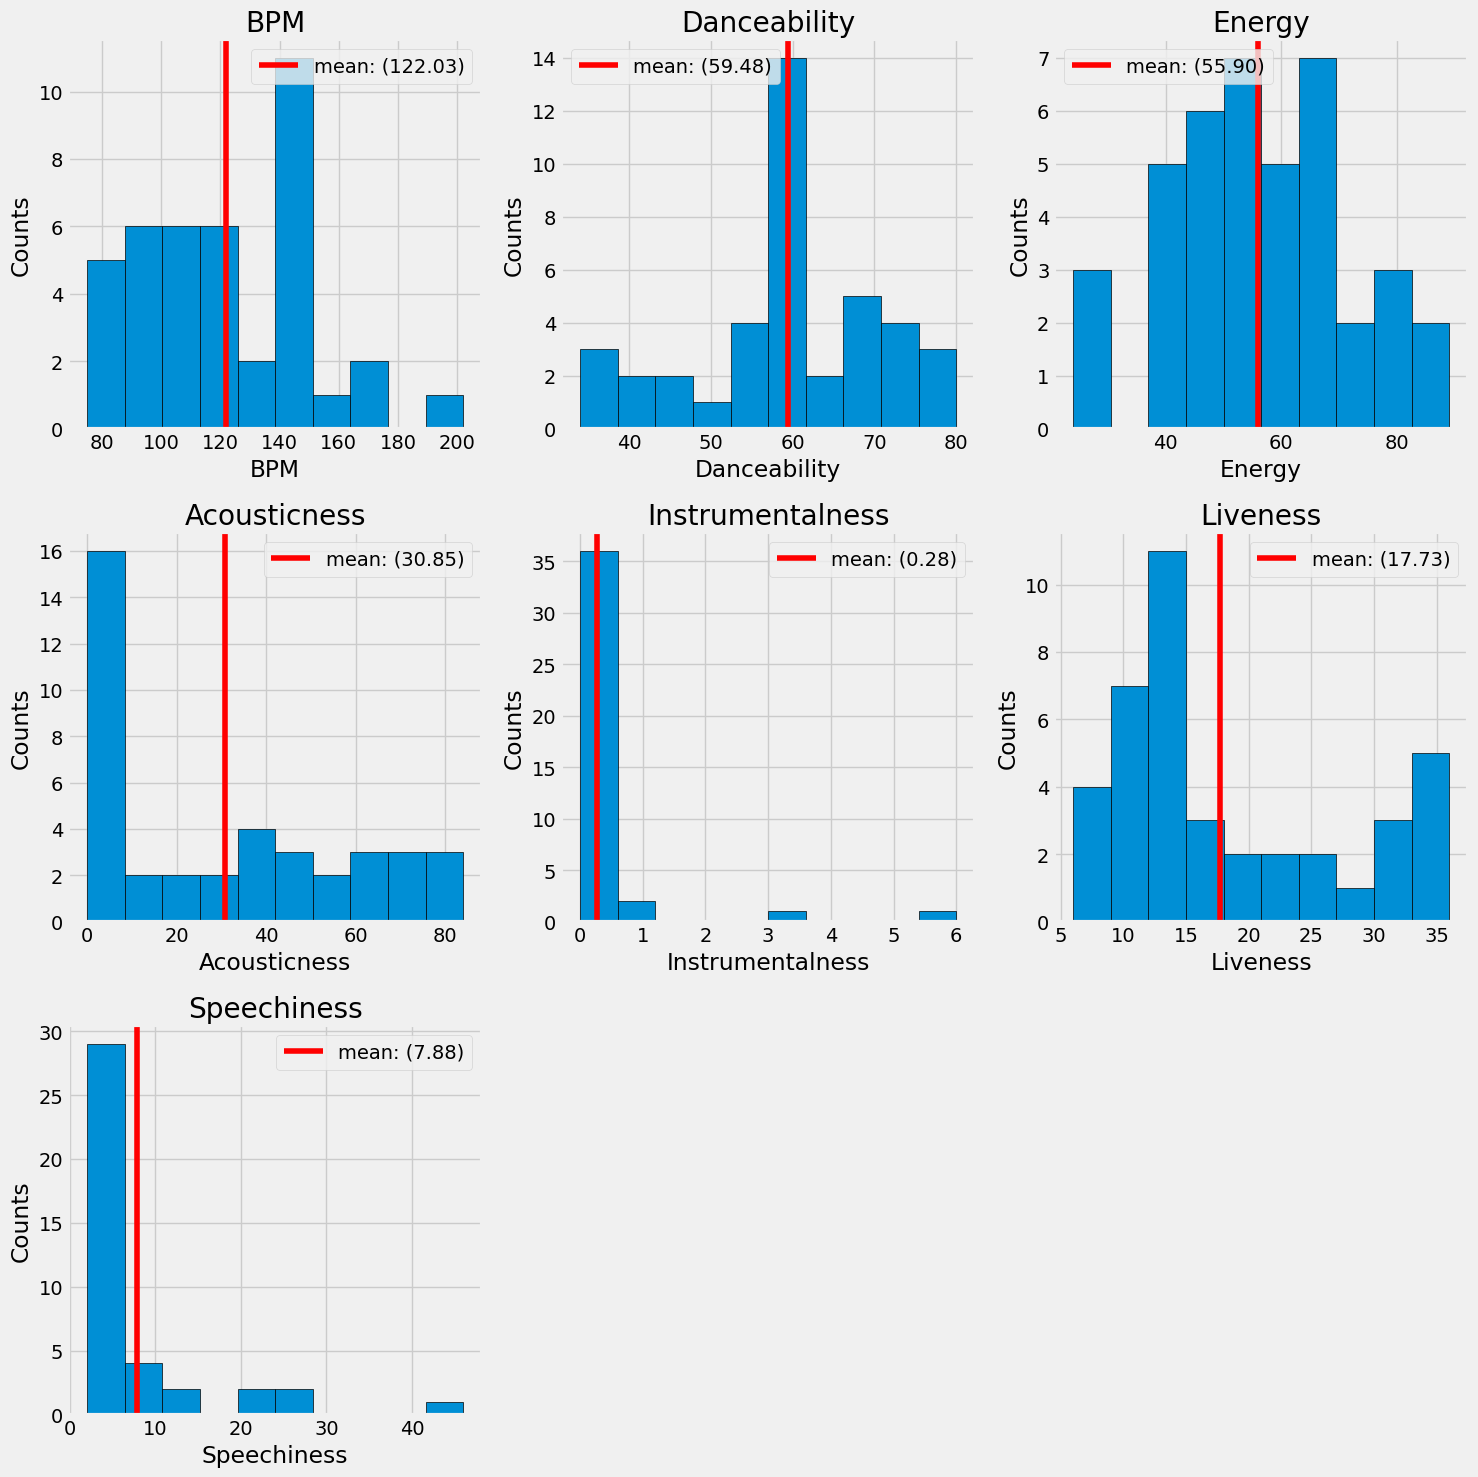

In [583]:
plot_playlist_hist(user_playlist[user_playlist["valence_%"]<50])

#### User playlist summery for positive songs

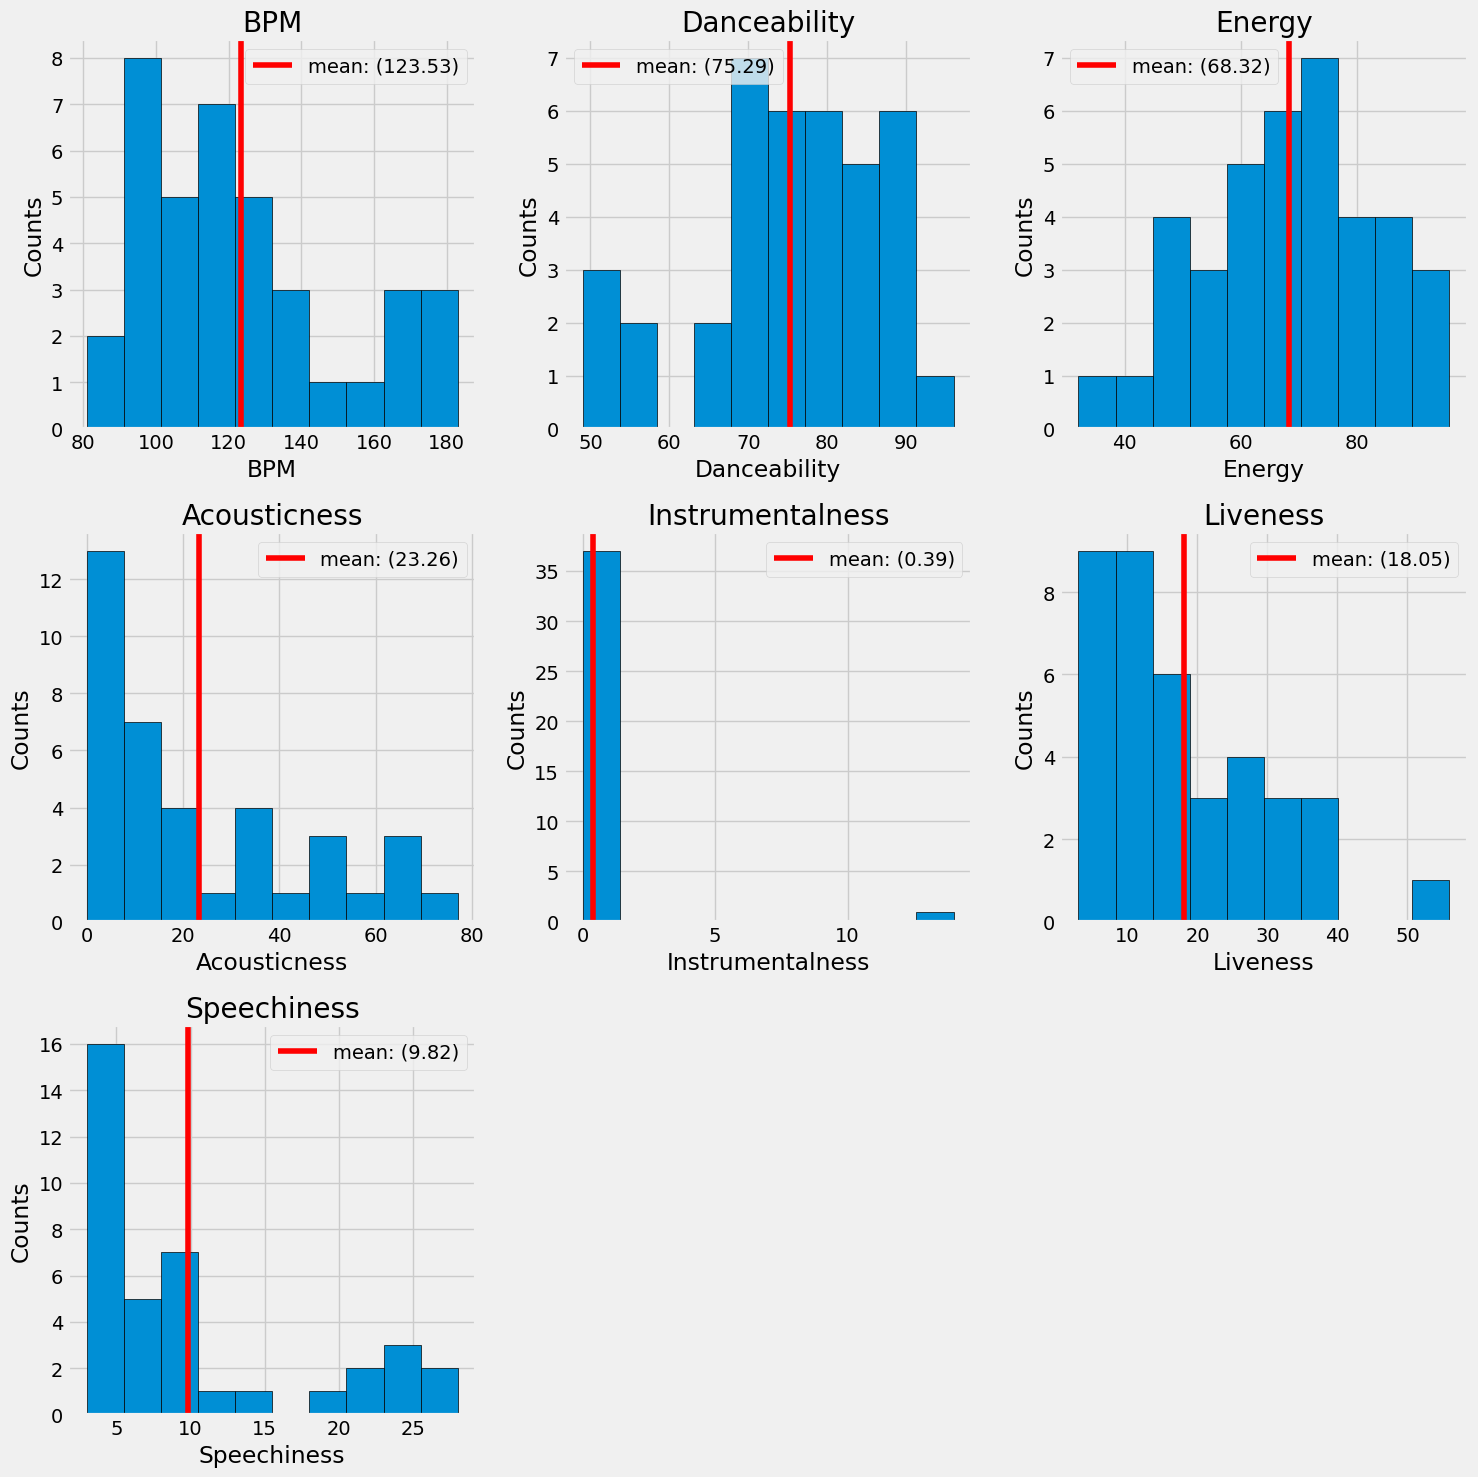

In [584]:
plot_playlist_hist(user_playlist[user_playlist["valence_%"]>50])

### Data Preprocessing

In [602]:
X = tweets["processed_text"].values
Y = tweets["target"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [614]:
def filter_values(value):
    filter_mask = []
    for item in Y_test:
        if item == value:
            filter_mask.append(True)
        else:
            filter_mask.append(False)
    print(filter_mask)
    return X_test[filter_mask]

#### Prepare ecommendation engine dataset

In [617]:
X_train_100_negative = filter_values(0)
X_train_100_negative = X_train_100_negative[:100]
X_train_100_positive = filter_values(1)
X_train_100_positive = X_train_100_positive[:100]

[True, True, True, True, True, True, False, True, True, False, False, False, False, True, False, False, False, True, True, True, True, False, False, False, True, True, False, True, True, False, False, True, True, True, True, True, True, False, True, False, False, False, False, False, False, True, False, True, False, True, False, False, True, False, False, True, False, False, True, False, True, False, False, False, False, False, True, True, False, True, True, True, False, False, False, True, False, False, False, True, False, True, False, False, True, True, True, False, True, False, False, False, False, False, False, False, False, True, True, True, False, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, False, True, False, False, True, True, False, True, True, True, False, False, True, False, False, True, True, True, False, True, False, True, True, True, False, True, True, True, False, False, False, False, True, False,

In [622]:
X_train_100_positive

array(['lunch dj come eat',
       'adventure need life glad great week thanks yr response',
       'zach make pee sitting grown gay man', 'sum day one word kackered',
       'great mind think alike', 'thanks follow nessie',
       'thanks guy added couple love handle inch tayyabs',
       'feeling quite sleepy today wish could stay bed today ok last year let go school',
       'whaddup whaddup whaddup whaddup whaddup got white girl swag head shoe whaddup',
       'congrats getting hadoop book esp zookeeper chapter',
       'working photo hillsong year celebration stay tuned www hillsong co za',
       'favorite word', 'absolutely right',
       'honestly depends woman love dress tend dip low back',
       'watching tv quot fast furious quot dang remember loved damn movie',
       'hahaha blakk reckkkin throwwwwwed',
       'roaming floor today need company busy',
       'hi sound like feeling bit better great great day',
       'dude got table readyyy fo u', 'hi carrie morning xxx',
 

#### Convert text data into numerical data

In [74]:
vectorizer = TfidfVectorizer()
print(X.shape, X_train.shape, X_test.shape)

(1599999,) (1279999,) (320000,)


In [75]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Logistic Regresion hyper-parameter tuning

In [76]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'solver' : ['lbfgs','newton-cg','sag','saga'],
    'l1_ratio': [1],
    'max_iter' : [1000]
    }
]

In [343]:
logModel = LogisticRegression()
clf = GridSearchCV(logModel, param_grid = param_grid, cv=3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train,Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Python(76278) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(76279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(76280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(76281) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(76282) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(76283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(76284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(76285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/pranto/Documents/Codes/project-made/made-template/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

#### Load the best model

In [77]:
best_clf = load('logistic_regression_model.joblib') 
# model = LogisticRegression(max_iter=5000)
# print(X.shape, X_train.shape, X_test.shape)

In [78]:
best_clf.best_estimator_

LogisticRegression(l1_ratio=1, max_iter=1000, solver='saga')

### Model Evaluation

In [79]:
X_train_prediction = best_clf.predict(X_train)
training_accuracy = accuracy_score(Y_train, X_train_prediction)
print("Training accuracy:", training_accuracy)

Training accuracy: 0.798415467512084


In [80]:
Y_test_prediction = best_clf.predict(X_test)
test_accuracy = accuracy_score(Y_test, Y_test_prediction)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.7783


In [81]:
conf_mat = cm(Y_test, Y_test_prediction)
print(conf_mat)

[[121068  38426]
 [ 32518 127988]]


#### Plot confusion matrix

Text(0.5, 1.0, 'Accuracy Score: 0.7783')

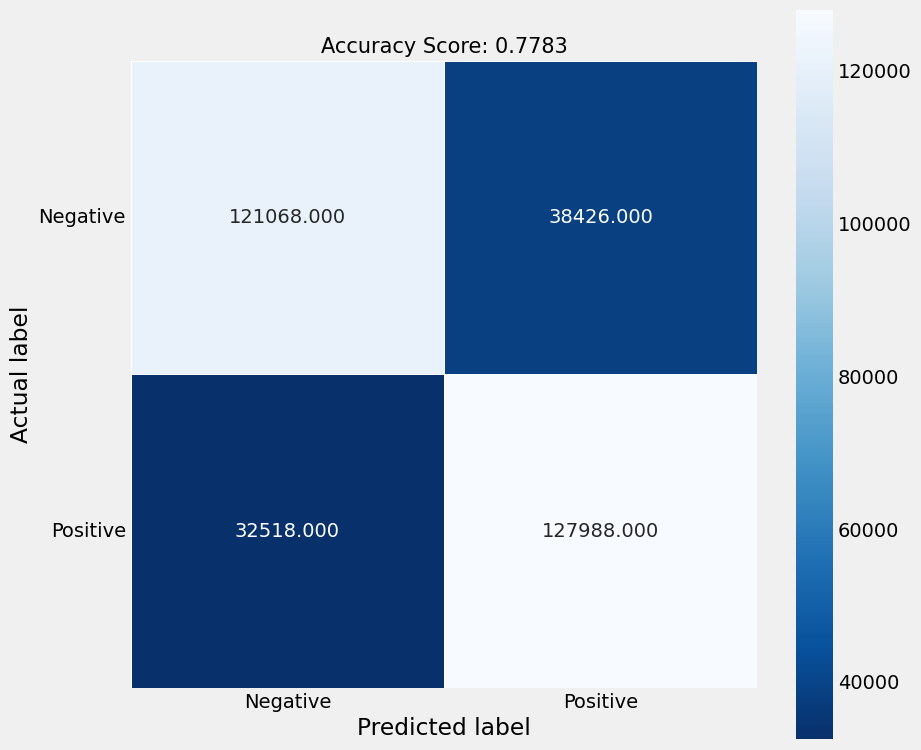

In [82]:
plt.figure(figsize=(9,9))
heat_map = sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
heat_map.set_yticklabels(['Negative', 'Positive'], rotation = 0)
heat_map.set_xticklabels(['Negative', 'Positive'], rotation = 0)
all_sample_title = f"Accuracy Score: {test_accuracy}"
plt.title(all_sample_title, size = 15)

In [83]:
predicted_probas = best_clf.predict_proba(X_test)
predicted_probas

array([[0.84563434, 0.15436566],
       [0.67413841, 0.32586159],
       [0.90445737, 0.09554263],
       ...,
       [0.05865501, 0.94134499],
       [0.73442313, 0.26557687],
       [0.51685557, 0.48314443]])

#### Plot ROC curve

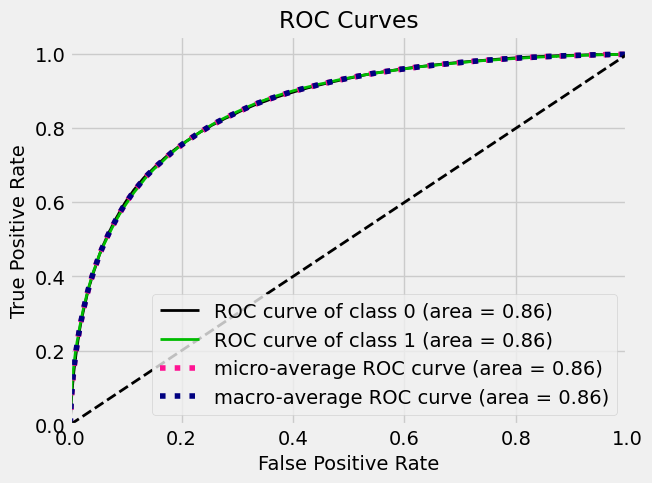

In [87]:
skplt.metrics.plot_roc(Y_test, predicted_probas)
plt.show()

In [88]:
print ('clasification report:\n', classification_report(Y_test, Y_test_prediction))

clasification report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77    159494
           1       0.77      0.80      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



### Recommendation engine evaluation

In [174]:
vectorizer = load('vectorizer.joblib') 

In [579]:
# Python imports
import random

# Third party imports
import pandas as pd

# Self imports


class SongsRecommendationEngine:
    def __init__(self, all_songs: pd.DataFrame, user_playlist: pd.DataFrame) -> None:
        self.audio_features_avg = {
            "bpm": 0,
            "danceability_%": 0,
            "energy_%": 0,
            "acousticness_%": 0,
            "instrumentalness_%": 0, 
            "liveness_%": 0,
            "speechiness_%": 0
        }
        self.all_songs = all_songs.copy()
        self.user_playlist = user_playlist.copy()
        for item in self.user_playlist["track_name"].values:
            self.all_songs = self.remove_subset_of_df(item)
    
    
    def remove_subset_of_df(self, identifier_to_be_removed: str):
        mask = self.all_songs["track_name"] == identifier_to_be_removed
        return self.all_songs[~mask]
    
    def calculate_avg_of_audio_features(self, songs: pd.DataFrame):
        for key, value in self.audio_features_avg.items():
            self.audio_features_avg[key] = songs[key].mean()

    def get_songs_aligned_with_audio_features_and_sentiment(self, sentiment: int):
        plus_minus_range = 15
        recommend_songs = self.all_songs.copy()
        if sentiment == 0:
            recommend_songs =  recommend_songs[recommend_songs["valence_%"] < 50]
        elif sentiment == 1:
            recommend_songs =  recommend_songs[recommend_songs["valence_%"] > 50]
            
        feature, _ = random.choice(list(self.audio_features_avg.items()))
        recommend_songs = recommend_songs[(recommend_songs["bpm"] > self.audio_features_avg["bpm"] - plus_minus_range) & (recommend_songs["bpm"] < self.audio_features_avg["bpm"] +plus_minus_range)]
        recommend_songs = recommend_songs[(recommend_songs["danceability_%"] > self.audio_features_avg["danceability_%"] - plus_minus_range) & (recommend_songs["danceability_%"] < self.audio_features_avg["danceability_%"] +plus_minus_range)]
        recommend_songs = recommend_songs[(recommend_songs["energy_%"] > self.audio_features_avg["energy_%"] - plus_minus_range) & (recommend_songs["energy_%"] < self.audio_features_avg["energy_%"] +plus_minus_range)]
        recommend_songs = recommend_songs[(recommend_songs["acousticness_%"] > self.audio_features_avg["acousticness_%"] - plus_minus_range) & (recommend_songs["acousticness_%"] < self.audio_features_avg["acousticness_%"] +plus_minus_range)]
        recommend_songs = recommend_songs[(recommend_songs["speechiness_%"] > self.audio_features_avg["speechiness_%"] - plus_minus_range) & (recommend_songs["speechiness_%"] < self.audio_features_avg["speechiness_%"] +plus_minus_range)]
        recommend_songs = recommend_songs[(recommend_songs["liveness_%"] > self.audio_features_avg["liveness_%"] - plus_minus_range) & (recommend_songs["liveness_%"] < self.audio_features_avg["liveness_%"] +plus_minus_range)]
        recommend_songs = recommend_songs[(recommend_songs["instrumentalness_%"] > self.audio_features_avg["instrumentalness_%"] - plus_minus_range) & (recommend_songs["instrumentalness_%"] < self.audio_features_avg["instrumentalness_%"] +plus_minus_range)]
        recommend_songs = recommend_songs.sort_values(feature, ascending=False)
        return recommend_songs
    
    def recommend_song(self, sentiment: int) -> pd.DataFrame:
        songs_aligned_with_sentiment = None
        if sentiment == 0:
            songs_aligned_with_sentiment = self.user_playlist[self.user_playlist["valence_%"] < 50]
        elif sentiment == 1:
            songs_aligned_with_sentiment = self.user_playlist[self.user_playlist["valence_%"] > 50]
        
        self.calculate_avg_of_audio_features(songs=songs_aligned_with_sentiment)
        
        recommended_songs = self.get_songs_aligned_with_audio_features_and_sentiment(sentiment=sentiment)
        return recommended_songs.sample(1)

In [232]:
song_recommendation_engine = SongsRecommendationEngine(all_songs=songs, user_playlist=user_playlist)

In [618]:
# from services.song_recommendation_engine import SongsRecommendationEngine
def measure_recommendation_engine_performance(tweets):
    user_tweets_vectorized = vectorizer.transform(tweets)
    user_sentiments = best_clf.predict(user_tweets_vectorized)
    audio_features_avg = {
        "bpm": list(),
        "danceability_%": list(),
        "energy_%": list(),
        "acousticness_%": list(),
        "instrumentalness_%": list(), 
        "liveness_%": list(),
        "speechiness_%": list()
    }
    for item in user_sentiments:
        recommended_song = song_recommendation_engine.recommend_song(sentiment=item)
        for key, value in audio_features_avg.items():
            audio_features_avg[key].append(recommended_song[key].values[0])
        
    recommendation_engine_performance = pd.DataFrame.from_dict(audio_features_avg)
    return recommendation_engine_performance

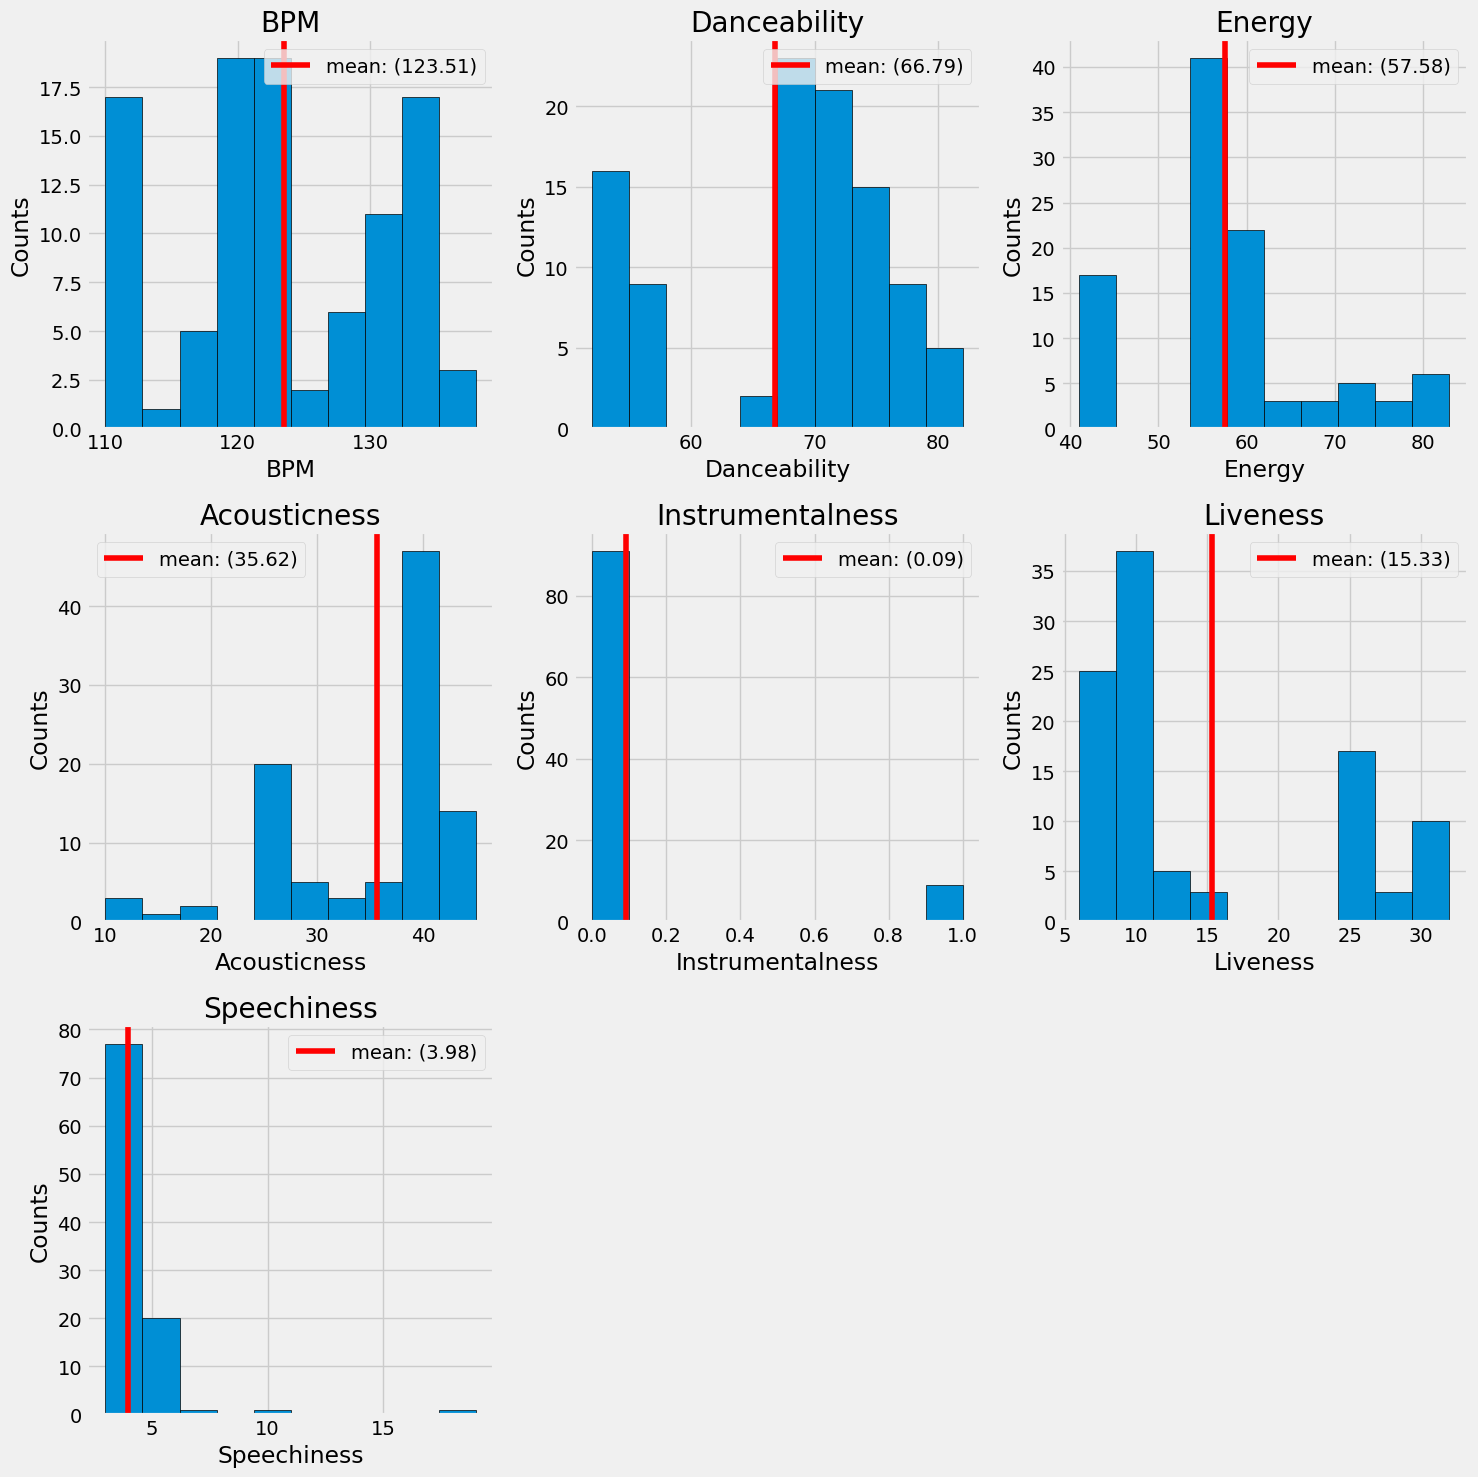

In [619]:
negative_recommendation_performance = measure_recommendation_engine_performance(tweets=X_train_100_negative)
plot_playlist_hist(playlist=negative_recommendation_performance)

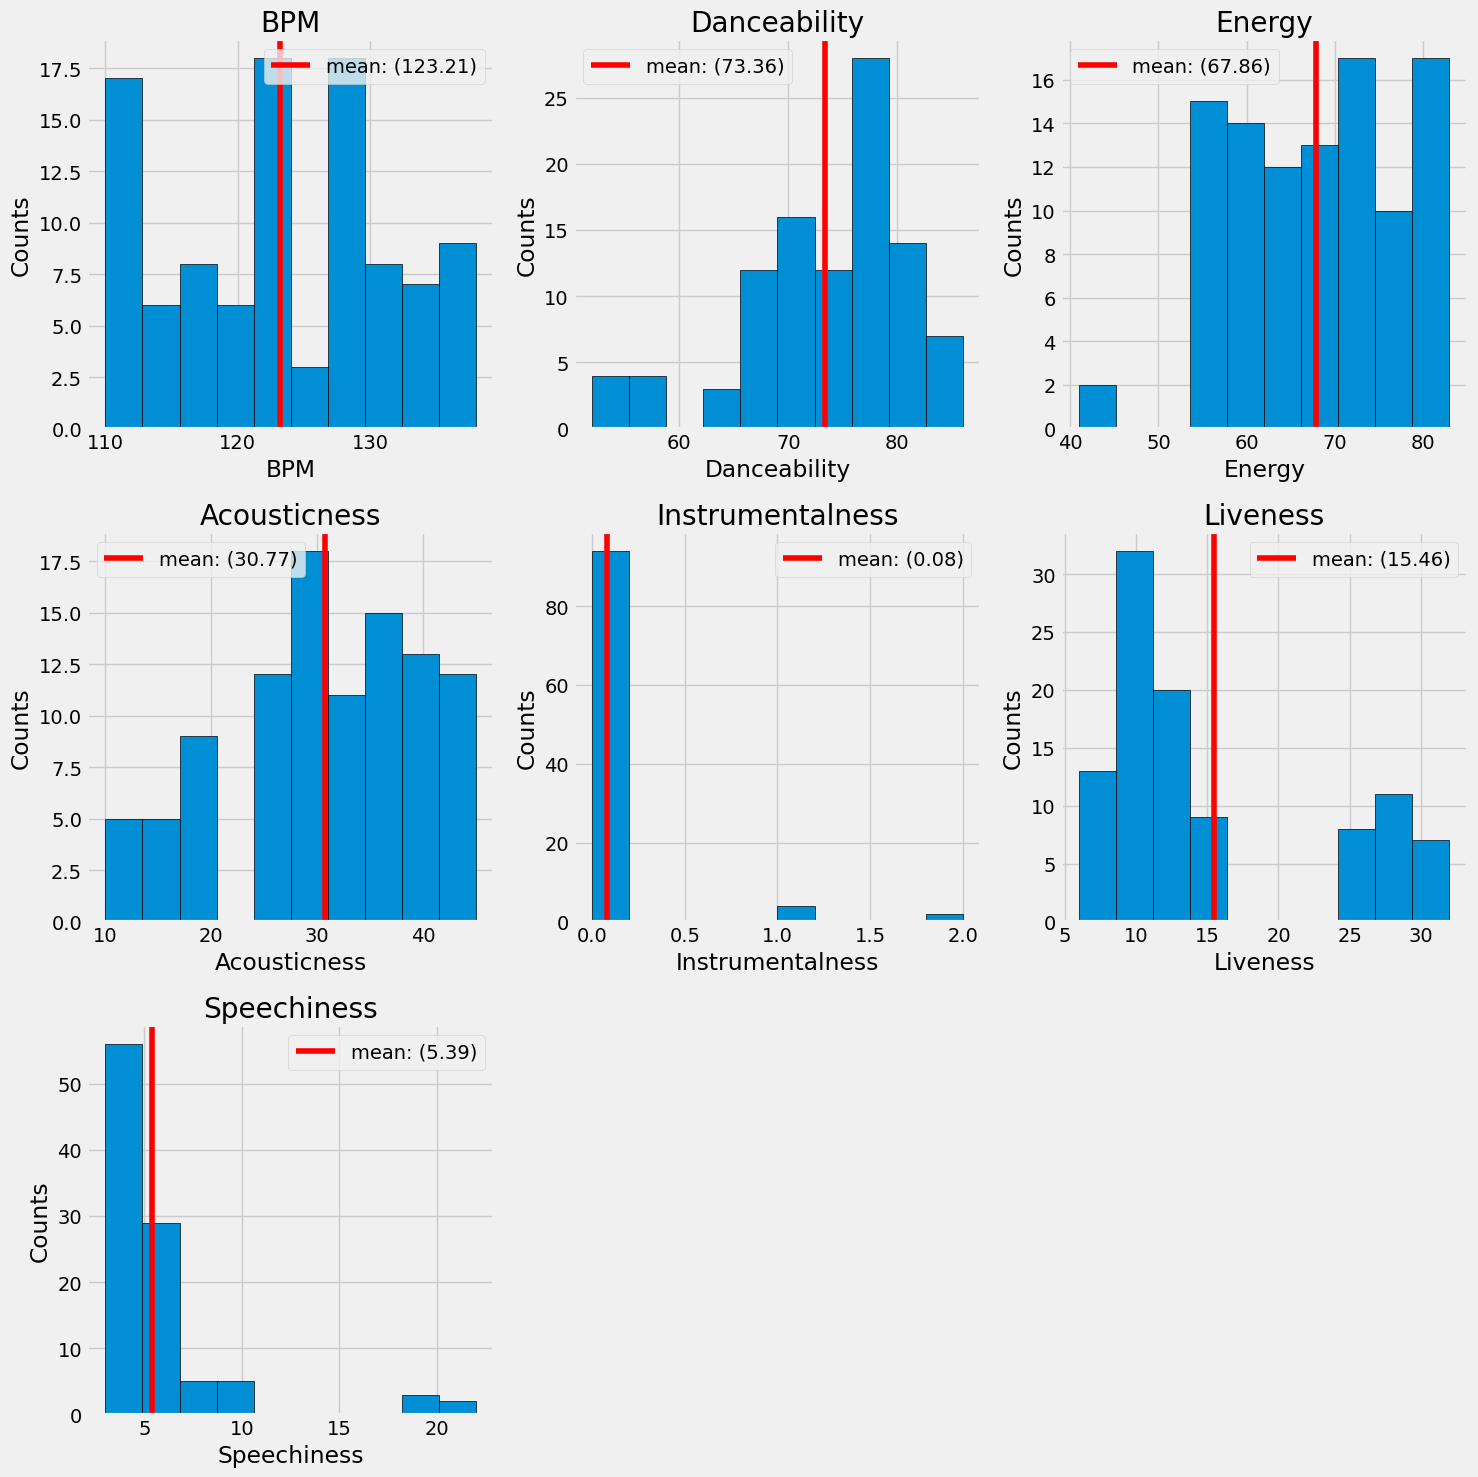

In [620]:
postive_recommendation_performance = measure_recommendation_engine_performance(tweets=X_train_100_positive)
plot_playlist_hist(playlist=postive_recommendation_performance)